# 📊 World Happiness Report — Proyecto Final Data Science

**Autor:** Jeremias Davison  
**Curso:** Coderhouse — Data Science  

## Resumen

Este proyecto analiza los factores que influyen en el nivel de felicidad de los países utilizando datos del World Happiness Report. A través de un análisis exploratorio de datos (EDA) y la aplicación de modelos de regresión, se identificaron relaciones significativas entre variables económicas, sociales y de bienestar. Los resultados muestran que la felicidad es un fenómeno multifactorial y que modelos no lineales permiten capturar mejor estas interacciones, alcanzando un buen desempeño predictivo.

Hallazgos clave (a partir del EDA y del modelo):
- Variables socioeconómicas como **PIB per cápita**, **apoyo social**, **expectativa de vida saludable** y **libertad para tomar decisiones** se relacionan positivamente con la felicidad.
- La **percepción de corrupción** tiende a relacionarse negativamente.
- Un modelo de regresión permite **predecir** el *Happiness score* con métricas cuantitativas (MAE/RMSE/R²) y, en modelos de ensamble, estimar **importancia de variables**.


## Objetivo

Construir un **Análisis Exploratorio de Datos (EDA)** completo y entrenar al menos un modelo de *machine learning* que permita:

1. **Entender** cómo se distribuye la felicidad y cómo se relaciona con variables económicas y sociales.
2. **Seleccionar** variables relevantes con un criterio experto apoyado por análisis descriptivo y gráfico.
3. **Predecir** el *Happiness score* de un país a partir de sus indicadores.

## Contexto comercial (imaginativo)

La consultora **Wellbeing Insights** asesora a gobiernos y ONG en proyectos de bienestar social. Su objetivo es detectar **palancas accionables** que suelen asociarse a mejoras en el bienestar (salud, redes de apoyo, libertad, calidad institucional).

Un modelo predictivo y un análisis interpretativo permiten:
- priorizar inversiones (por ejemplo, salud pública vs. instituciones vs. programas comunitarios),
- comparar países “pares”,
- y detectar “outliers” (países más felices o menos felices de lo esperado dado su nivel económico).


## Hipótesis

H1. **A mayor PIB per cápita, mayor Happiness Score.**

H2. **La libertad para tomar decisiones diarias se correlaciona más con la felicidad que el apoyo social.**

H3. **A mayor percepción de corrupción, menor Happiness Score.**

H4. **La combinación de PIB alto, mayor expectativa de vida y mayor libertad se asocia a países más felices.**


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", None)


## 1. Carga de datos

El dataset se espera en el mismo directorio del notebook con el nombre `world_happiness_combined.csv`.

In [3]:
df = pd.read_csv("/content/world_happiness_combined.csv", sep=';')
display(df.head())

,Ranking,Country,Regional indicator,Happiness score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Year
0,1,Switzerland,Western Europe,"7,58700","8,26132","0,96240",73,"0,99379","0,37289","0,23941",2015
1,2,Iceland,Western Europe,"7,56100","7,70416","1,00000",73,"0,93884","0,54819","0,74371",2015
2,3,Denmark,Western Europe,"7,52700","7,84114","0,97030",70,"0,96962","0,42894","0,12382",2015
3,4,Norway,Western Europe,"7,52200","8,63100","0,94917",71,"1,00000","0,43598","0,33860",2015
4,5,Canada,North America and ANZ,"7,42700","7,84595","0,94322",71,"0,94511","0,57560","0,40285",2015


In [4]:
display(df.shape)
df.info()

# Resumen estadístico de las variables numéricas
df.describe()

# Valores faltantes por columna
df.isnull().sum()

# Registros duplicados
df.duplicated().sum()

(1502, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502 entries, 0 to 1501
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Ranking                       1502 non-null   int64 
 1   Country                       1502 non-null   object
 2   Regional indicator            1499 non-null   object
 3   Happiness score               1502 non-null   object
 4   GDP per capita                1502 non-null   object
 5   Social support                1502 non-null   object
 6   Healthy life expectancy       1502 non-null   int64 
 7   Freedom to make life choices  1502 non-null   object
 8   Generosity                    1502 non-null   object
 9   Perceptions of corruption     1502 non-null   object
 10  Year                          1502 non-null   int64 
dtypes: int64(3), object(8)
memory usage: 129.2+ KB


np.int64(0)

## 2. Exploración inicial

Revisamos dimensiones, tipos, duplicados y valores faltantes.


In [5]:
# Duplicados
dup = df.duplicated().sum()
missing = df.isna().sum().sort_values(ascending=False)

dup, missing.head(15)


(np.int64(0),
 Regional indicator              3
 Ranking                         0
 Country                         0
 Happiness score                 0
 GDP per capita                  0
 Social support                  0
 Healthy life expectancy         0
 Freedom to make life choices    0
 Generosity                      0
 Perceptions of corruption       0
 Year                            0
 dtype: int64)

## 3. Limpieza y preparación

Algunas columnas numéricas vienen como texto (por separador decimal `,`). Normalizamos a `float` de forma segura.


In [6]:
# Intento de conversión a numérico para todas las columnas (excepto obvias categóricas)
# Ajustá esta lista si tu dataset tiene más columnas de texto.
categorical_cols = [c for c in df.columns if df[c].dtype == "object" and c.lower() in ["country", "region", "year"]]

def to_float_series(s: pd.Series) -> pd.Series:
    # Convierte strings con coma decimal a float; deja NaN si no puede.
    return pd.to_numeric(s.astype(str).str.replace(",", ".", regex=False), errors="coerce")

numeric_candidate_cols = [c for c in df.columns if c not in categorical_cols]

for c in numeric_candidate_cols:
    if df[c].dtype == "object":
        df[c] = to_float_series(df[c])

df.dtypes


,0
Ranking,int64
Country,object
Regional indicator,float64
Happiness score,float64
GDP per capita,float64
Social support,float64
Healthy life expectancy,int64
Freedom to make life choices,float64
Generosity,float64
Perceptions of corruption,float64


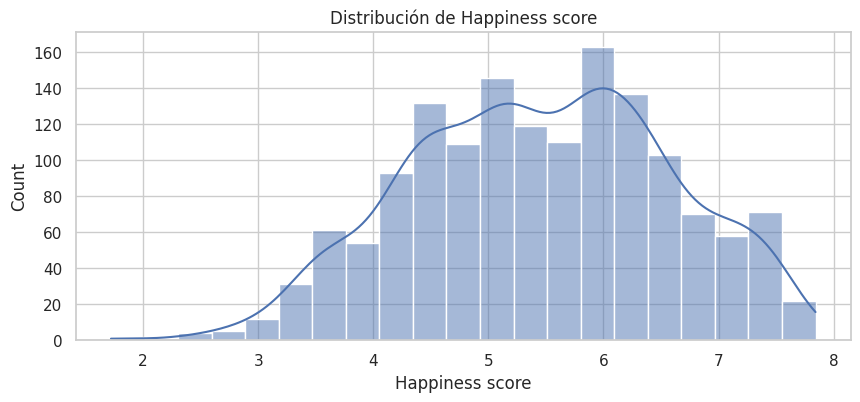

In [8]:
TARGET = "Happiness score"

plt.figure(figsize=(10,4))
sns.histplot(df[TARGET], kde=True)
plt.title("Distribución de Happiness score")
plt.show()


## 4. Exploración de relaciones (Hipótesis)


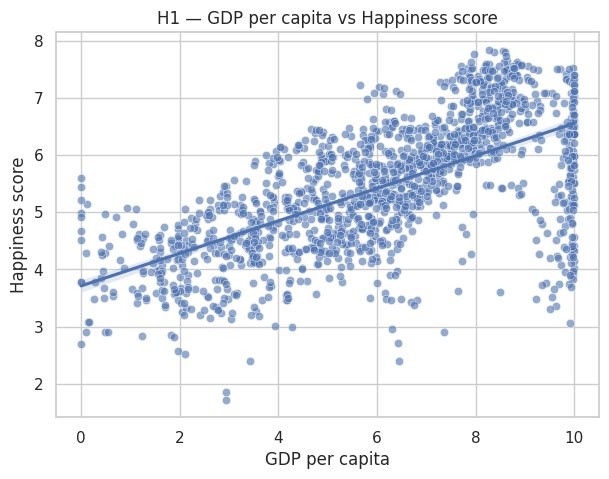

In [9]:
# H1: PIB per cápita vs felicidad
x1 = "GDP per capita"

plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x=x1, y=TARGET, alpha=0.6)
sns.regplot(data=df, x=x1, y=TARGET, scatter=False)
plt.title("H1 — GDP per capita vs Happiness score")
plt.show()


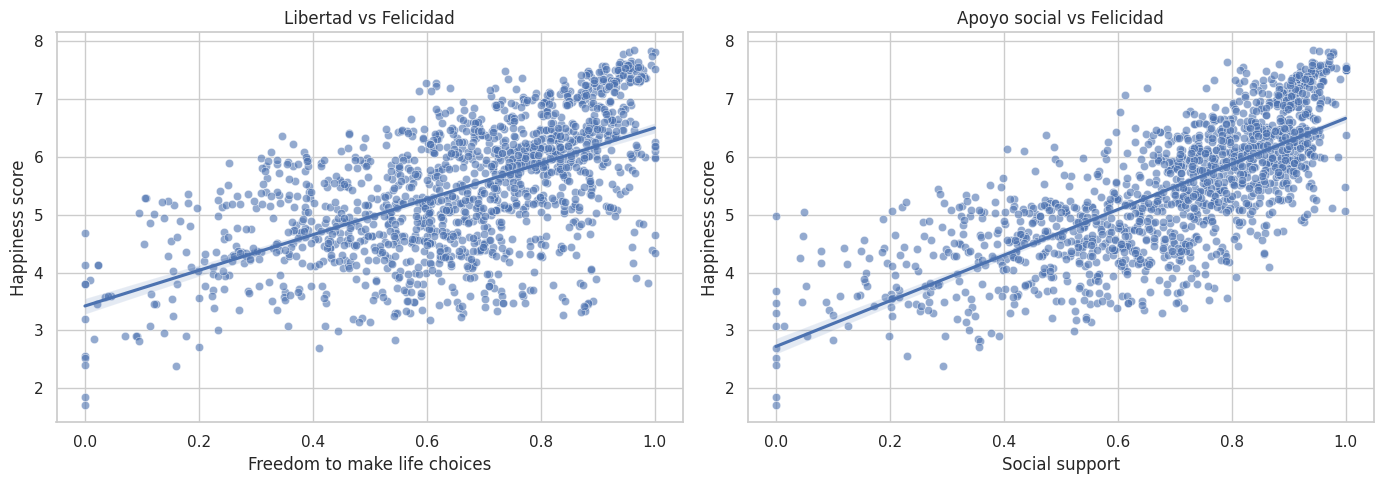

In [10]:
# H2: Libertad vs Apoyo social
x2a = "Freedom to make life choices"
x2b = "Social support"

fig, axes = plt.subplots(1, 2, figsize=(14,5))
sns.scatterplot(data=df, x=x2a, y=TARGET, ax=axes[0], alpha=0.6)
sns.regplot(data=df, x=x2a, y=TARGET, ax=axes[0], scatter=False)
axes[0].set_title("Libertad vs Felicidad")

sns.scatterplot(data=df, x=x2b, y=TARGET, ax=axes[1], alpha=0.6)
sns.regplot(data=df, x=x2b, y=TARGET, ax=axes[1], scatter=False)
axes[1].set_title("Apoyo social vs Felicidad")

plt.tight_layout()
plt.show()


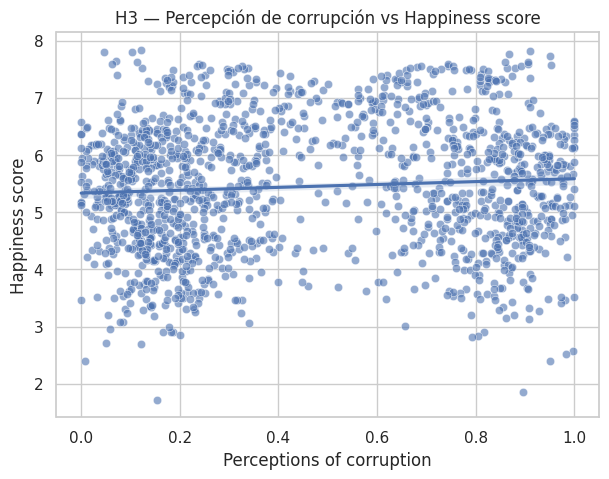

In [11]:
# H3: Corrupción percibida vs felicidad
x3 = "Perceptions of corruption"

plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x=x3, y=TARGET, alpha=0.6)
sns.regplot(data=df, x=x3, y=TARGET, scatter=False)
plt.title("H3 — Percepción de corrupción vs Happiness score")
plt.show()


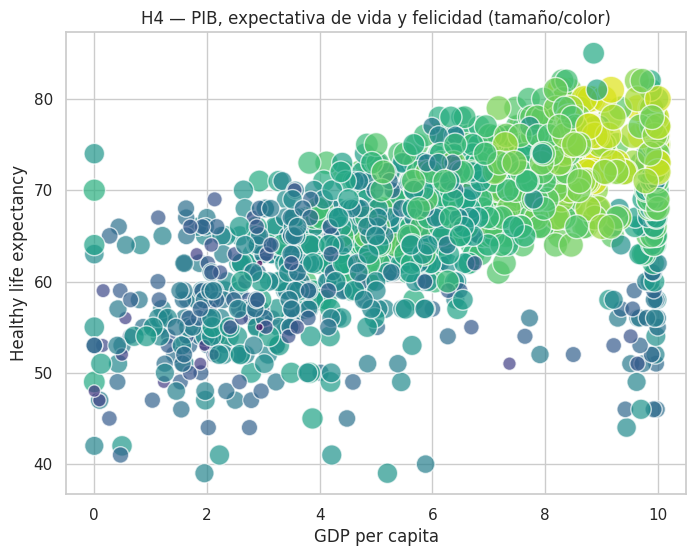

In [12]:
# H4: relación multivariable (ejemplo con burbujas)
x4 = "GDP per capita"
y4 = "Healthy life expectancy"

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df, x=x4, y=y4,
    size=TARGET, sizes=(20, 400),
    hue=TARGET, palette="viridis", alpha=0.7, legend=False
)
plt.title("H4 — PIB, expectativa de vida y felicidad (tamaño/color)")
plt.show()


## 5. Selección de variables (criterio experto)

Antes de modelar, elegimos variables basadas en:
- Correlaciones con el target
- Redundancia entre variables


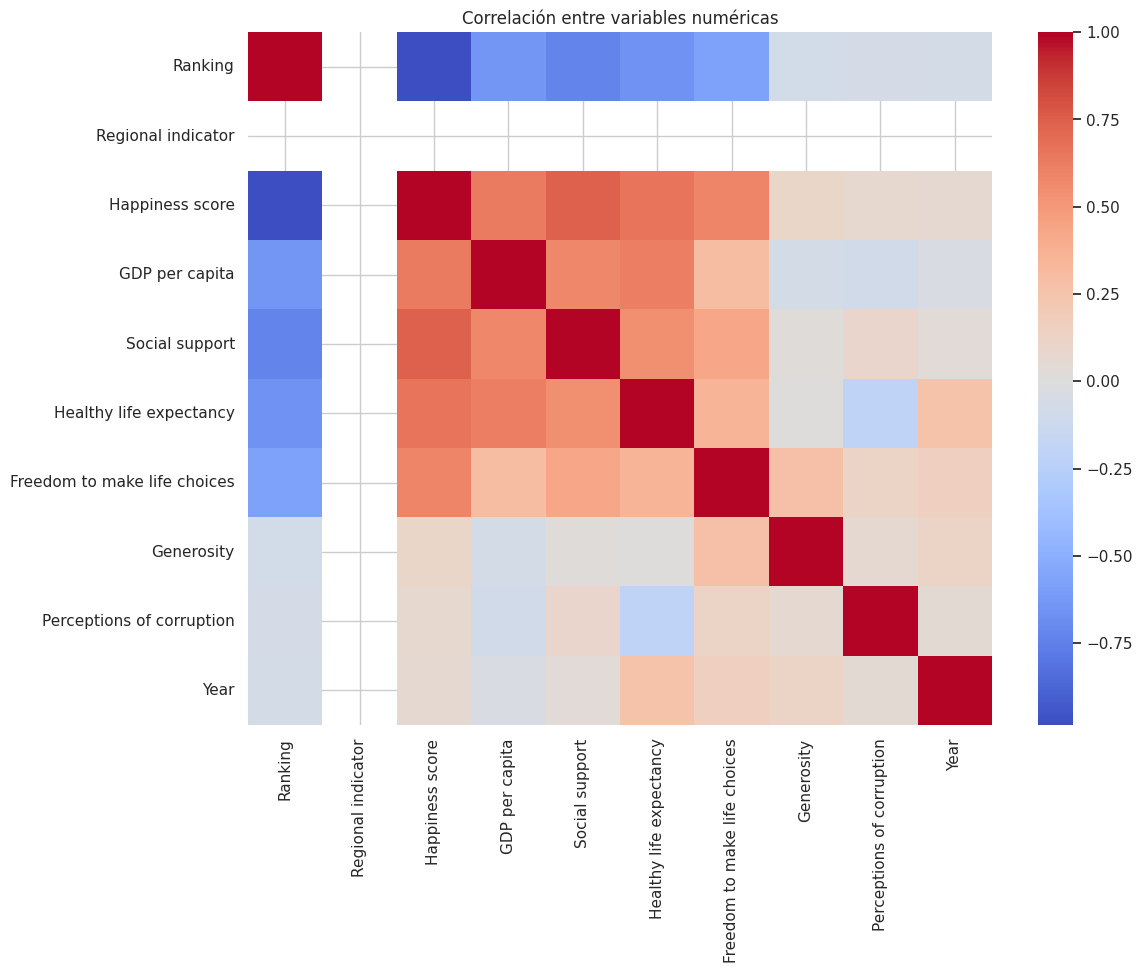

,Happiness score
Happiness score,1.000000
Social support,0.744092
Healthy life expectancy,0.659959
GDP per capita,0.631353
Freedom to make life choices,0.591207
Generosity,0.105558
Perceptions of corruption,0.071776
Year,0.062231
Ranking,-0.984786
Regional indicator,NaN


In [13]:
# Matriz de correlación (solo numéricas)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[num_cols].corr(numeric_only=True)

plt.figure(figsize=(12,9))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlación entre variables numéricas")
plt.show()

corr[TARGET].sort_values(ascending=False).head(15)


In [14]:
# Variables elegidas
feature_cols = [
    "GDP per capita",
    "Social support",
    "Healthy life expectancy",
    "Freedom to make life choices",
    "Perceptions of corruption",
]


## 6. Modelado

Se entrena un modelo de regresión para predecir el *Happiness score*.

Compararemos:
- **Regresión lineal / Ridge** (baseline interpretable)
- **Random Forest Regressor** (no lineal, captura interacciones)


In [15]:
# Dataset final para modelado
model_df = df[feature_cols + [TARGET]].copy()

X = model_df[feature_cols]
y = model_df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

numeric_features = feature_cols

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]), numeric_features)
    ],
    remainder="drop"
)


In [19]:
# Modelo
lin_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Ridge(alpha=1.0, random_state=42))
])

rf_model = Pipeline(steps=[
    ("preprocess", ColumnTransformer(
        transformers=[("num", SimpleImputer(strategy="median"), numeric_features)],
        remainder="drop"
    )),
    ("model", RandomForestRegressor(
        n_estimators=400, random_state=42, n_jobs=-1
    ))
])

models = {
    "Ridge": lin_model,
    "RandomForest": rf_model
}


In [20]:
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

def eval_regression(model, X_train, y_train, X_test, y_test, name="model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return {"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2}


# **Análisis de valores atípicos**

Durante el análisis explorado se evaluaron posibles valores atípicos en las variables numéricas. No se eliminaron observaciones extremas, ya que los valores representan países reales con características socioeconómicas particulares y no errores de medición. Eliminar estos datos podría distorsionar la interpretación del fenómeno estudiado.

In [21]:
results = []
for name, m in models.items():
    results.append(eval_regression(m, X_train, y_train, X_test, y_test, name=name))

results_df = pd.DataFrame(results).sort_values("RMSE")
results_df


,Model,MAE,RMSE,R2
1,RandomForest,0.355760,0.468485,0.804046
0,Ridge,0.419354,0.525867,0.753104


## 7. Conclusiones

En este proyecto se desarrolló un análisis exploratorio y predictivo utilizando datos del World Happiness Report. A través del EDA se identificaron relaciones significativas entre variables socioeconómicas y el nivel de felicidad.

Tras la selección de variables basada en análisis descriptivos y correlacionales, se entrenaron modelos de regresión Ridge y Random Forest. Los resultados indican que el modelo Random Forest ofrece un mejor desempeño predictivo, con un R² cercano al 80%, lo que evidencia la presencia de relaciones no lineales en los datos.

Estos resultados permiten concluir que la felicidad de un país no depende de un único factor, sino de la interacción entre condiciones económicas, sociales e institucionales, información clave para la toma de decisiones en políticas públicas y estrategias de bienestar.

# **Validación de hipótesis**

Los resultados del EDA y del modelado confirman que existe una relación significativa entre variables socioeconómicas y el nivel de felicidad. Si bien ninguna variable por sí sola explica completamente el fenómeno, el análisis multivariable permite capturar interacciones complejas, validando las hipótesis planteadas al inicio del proyecto.